In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("talhasar/genki4k")

print("Path to dataset files:", path)

100%|██████████| 25.0M/25.0M [00:00<00:00, 90.7MB/s]

Extracting model files...


Path to dataset files: /root/.cache/kagglehub/datasets/talhasar/genki4k/versions/1


In [2]:
!pip install tf-keras
!pip install retina-face

In [3]:
"""
giving each image of the dataset to retina face, detecting faces and cropp them.
the cropped images is saved into the output path in 2 folders(smile and non_smile).

"""
import os
import cv2
from retinaface import RetinaFace


input_path = path + '/kaggle-genki4k'
output_path = '/root/.cache/kagglehub/datasets/cropped_genki4k'


classes = ['smile', 'non_smile']
fixed_size = (128, 128)

for class_name in classes:
    os.makedirs(os.path.join(output_path, class_name), exist_ok=True)

for class_name in classes:
    class_input_path = os.path.join(input_path, class_name)
    class_output_path = os.path.join(output_path, class_name)

    for image_name in os.listdir(class_input_path):
        image_path = os.path.join(class_input_path, image_name)

        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not read image {image_path}. Skipping.")
            continue

        # Detect faces in the image
        faces = RetinaFace.detect_faces(image_path)

        if isinstance(faces, dict):
            for i, key in enumerate(faces.keys()):
                # Get face coordinates and crop the image
                face = faces[key]
                facial_area = face['facial_area']
                x1, y1, x2, y2 = facial_area

                # Crop the face from the image
                cropped_face = image[y1:y2, x1:x2]
                cropped_face = cv2.resize(cropped_face, fixed_size)

                # Save the cropped face to the new directory
                output_image_path = os.path.join(class_output_path, f"{os.path.splitext(image_name)[0]}_face_{i}.jpg")
                cv2.imwrite(output_image_path, cropped_face)

                print(f"Saved cropped face to {output_image_path}")
        else:
            print(f"No face detected in {image_path}.")


24-11-15 15:50:17 - Directory /root/.deepface created
24-11-15 15:50:17 - Directory /root/.deepface/weights created
24-11-15 15:50:17 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:01<00:00, 109MB/s] 


Saved cropped face to /root/.cache/kagglehub/datasets/cropped_genki4k/smile/file0216_face_0.jpg
Saved cropped face to /root/.cache/kagglehub/datasets/cropped_genki4k/smile/file0121_face_0.jpg
Saved cropped face to /root/.cache/kagglehub/datasets/cropped_genki4k/smile/file2151_face_0.jpg
Saved cropped face to /root/.cache/kagglehub/datasets/cropped_genki4k/smile/file1272_face_0.jpg
Saved cropped face to /root/.cache/kagglehub/datasets/cropped_genki4k/smile/file0943_face_0.jpg
Saved cropped face to /root/.cache/kagglehub/datasets/cropped_genki4k/smile/file1412_face_0.jpg
Saved cropped face to /root/.cache/kagglehub/datasets/cropped_genki4k/smile/file1322_face_0.jpg
Saved cropped face to /root/.cache/kagglehub/datasets/cropped_genki4k/smile/file2131_face_0.jpg
Saved cropped face to /root/.cache/kagglehub/datasets/cropped_genki4k/smile/file1762_face_0.jpg
Saved cropped face to /root/.cache/kagglehub/datasets/cropped_genki4k/smile/file1050_face_0.jpg
Saved cropped face to /root/.cache/kaggl

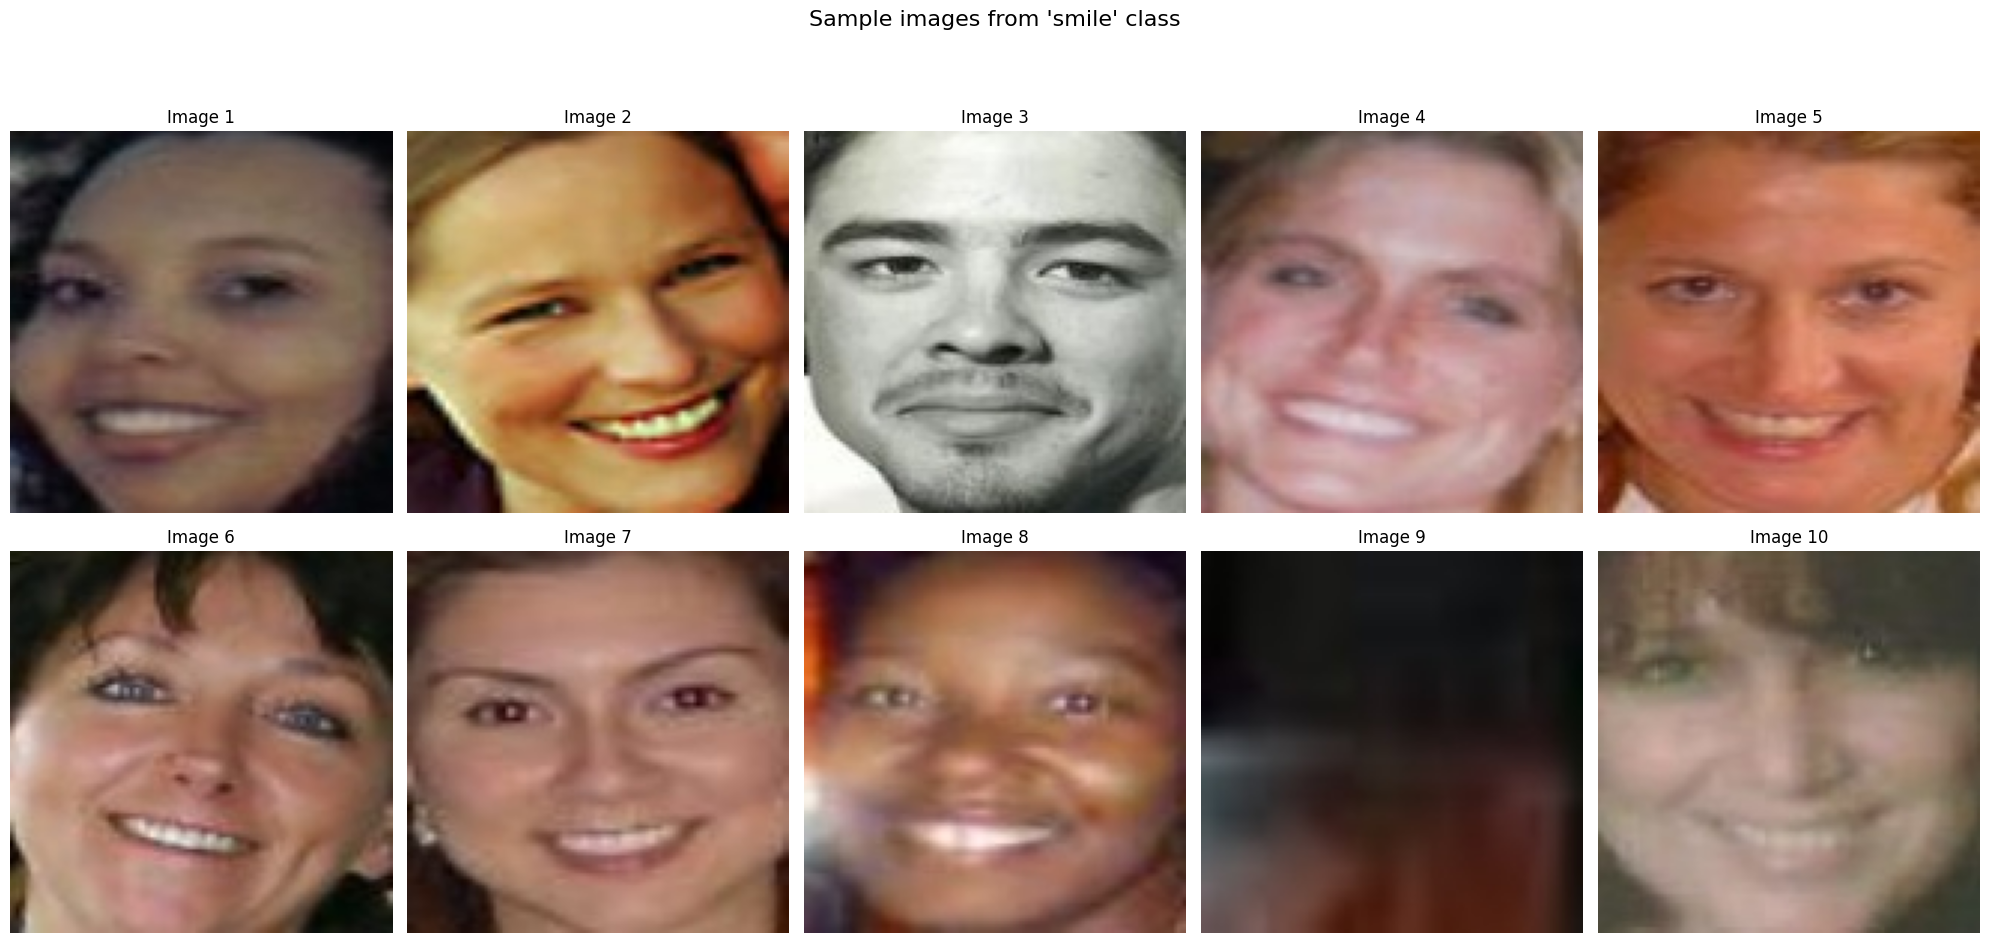

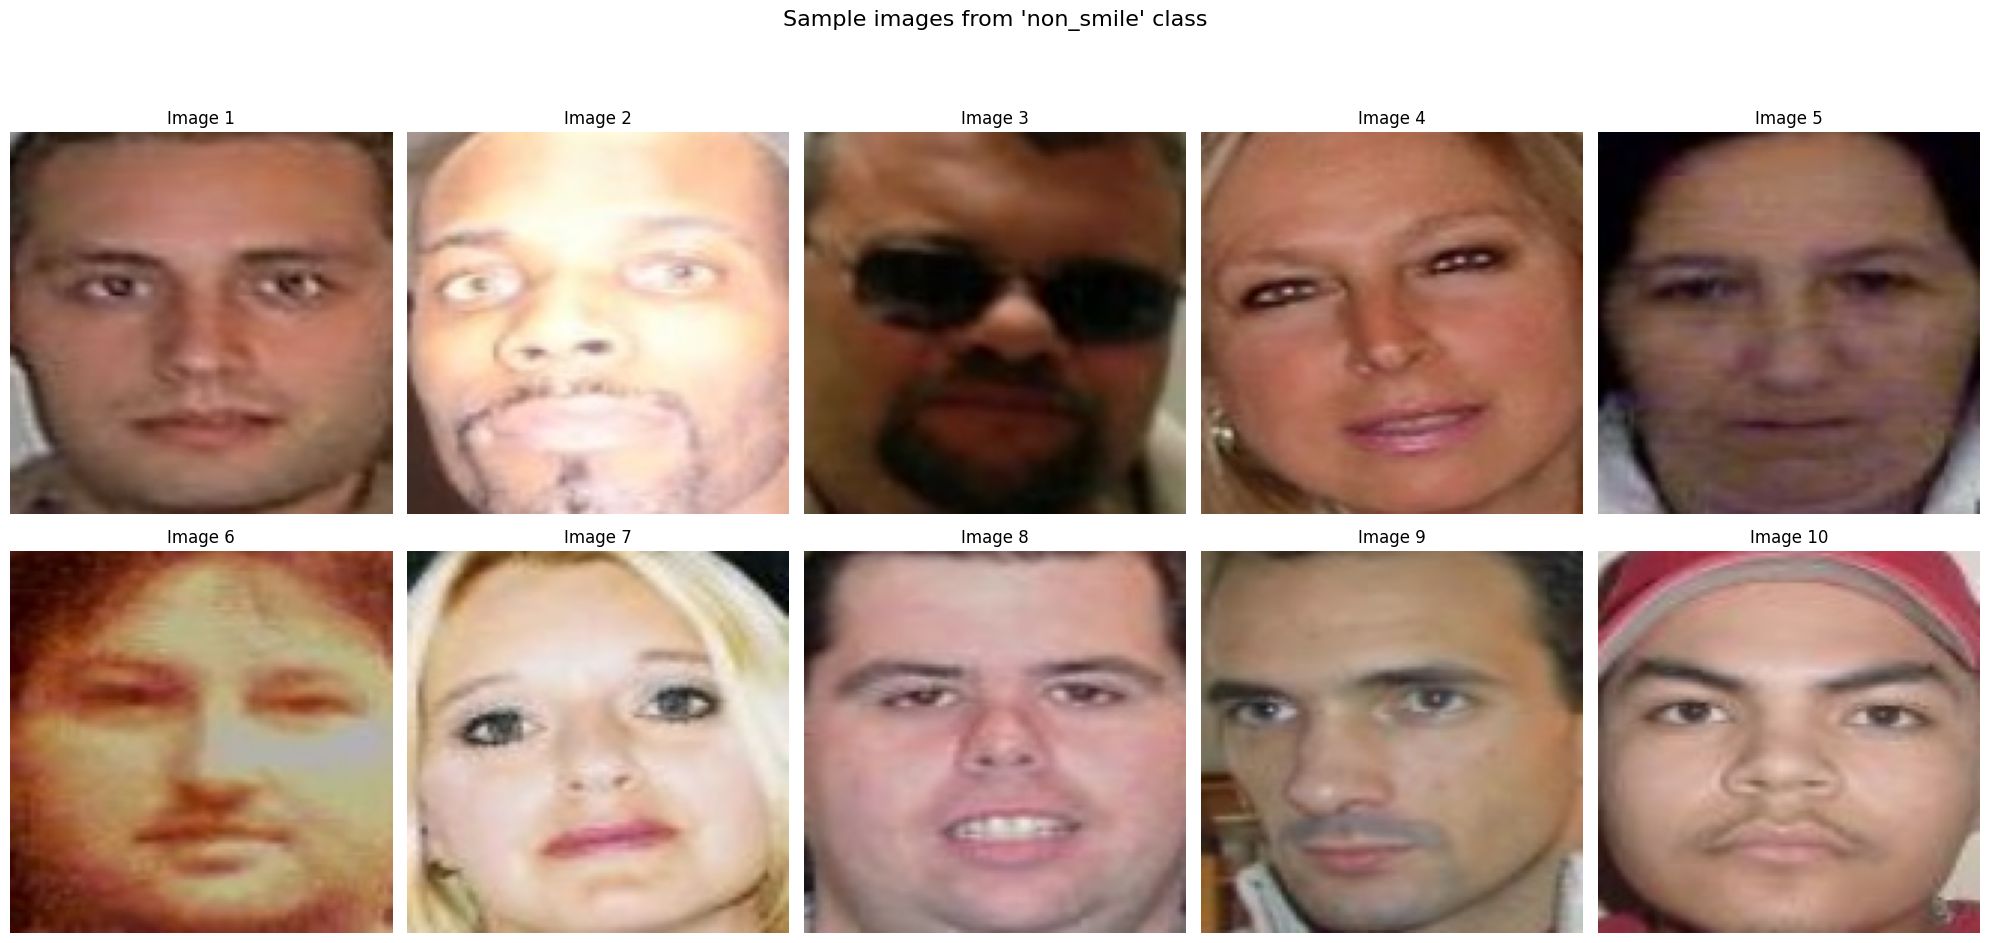

In [4]:
"""
show some images from cropped ones

"""
import os
import cv2
import matplotlib.pyplot as plt

# Number of images to display
num_images = 10

# Display images from each class
for class_name in classes:
    class_path = os.path.join(output_path, class_name)
    image_files = os.listdir(class_path)

    # Select a subset of images to display
    image_files = image_files[:num_images]

    # Plot the images
    plt.figure(figsize=(20, 10))
    plt.suptitle(f"Sample images from '{class_name}' class", fontsize=16)

    for i, image_name in enumerate(image_files):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

        # Display the image in a subplot
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Image {i + 1}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [5]:
!pip install face-alignment
!pip install torch

In [6]:
"""
align cropped images.

"""
import os
import cv2
import torch
import numpy as np
import face_alignment
from matplotlib import pyplot as plt

# Initialize the face alignment module
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, device='cuda' if torch.cuda.is_available() else 'cpu')

#output_path = '/root/.cache/kagglehub/datasets/cropped_genki4k'
output_aligned_path = '/root/.cache/kagglehub/datasets/aligned_cropped_genki4k'
classes = ['smile', 'non_smile']

# Create output directories for aligned images if they don't exist
for class_name in classes:
    os.makedirs(os.path.join(output_aligned_path, class_name), exist_ok=True)

# Function to align face using eye landmarks
def align_face(image, landmarks, target_size=(128, 128)):
    # Select coordinates for left and right eyes (landmarks 36-39 for left, 42-45 for right)
    left_eye = np.mean(landmarks[36:42], axis=0)
    right_eye = np.mean(landmarks[42:48], axis=0)

    # Calculate the angle between the eye centroids
    delta_x = right_eye[0] - left_eye[0]
    delta_y = right_eye[1] - left_eye[1]
    angle = np.degrees(np.arctan2(delta_y, delta_x))

    # Calculate center between the eyes
    eye_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)

    # Get the rotation matrix for rotating the image around the eye center
    M = cv2.getRotationMatrix2D(eye_center, angle, scale=1.0)

    # Perform the rotation
    aligned_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC)

    # Resize the aligned image to the target size
    aligned_image_resized = cv2.resize(aligned_image, target_size)

    return aligned_image_resized

# Iterate through each class and its images
for class_name in classes:
    class_input_path = os.path.join(output_path, class_name)
    class_output_path = os.path.join(output_aligned_path, class_name)

    for image_name in os.listdir(class_input_path):
        image_path = os.path.join(class_input_path, image_name)

        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not read image {image_path}. Skipping.")
            continue

        # Convert the image to RGB for the face alignment library
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get landmarks for face alignment
        landmarks = fa.get_landmarks(image_rgb)

        if landmarks:
            # Align the image using the landmarks
            aligned_face = align_face(image_rgb, landmarks[0])

            # Convert aligned face back to BGR for saving with OpenCV
            aligned_face_bgr = cv2.cvtColor(aligned_face, cv2.COLOR_RGB2BGR)

            # Save the aligned image
            output_image_path = os.path.join(class_output_path, image_name)
            cv2.imwrite(output_image_path, aligned_face_bgr)

            print(f"Aligned image saved to {output_image_path}")
        else:
            print(f"No landmarks detected in {image_path}. Skipping.")


Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth
100%|██████████| 85.7M/85.7M [00:05<00:00, 17.6MB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip
100%|██████████| 91.9M/91.9M [00:05<00:00, 16.9MB/s]


Aligned image saved to /root/.cache/kagglehub/datasets/aligned_cropped_genki4k/smile/file0788_face_0.jpg
Aligned image saved to /root/.cache/kagglehub/datasets/aligned_cropped_genki4k/smile/file1688_face_1.jpg
Aligned image saved to /root/.cache/kagglehub/datasets/aligned_cropped_genki4k/smile/file0491_face_0.jpg
Aligned image saved to /root/.cache/kagglehub/datasets/aligned_cropped_genki4k/smile/file1700_face_0.jpg
Aligned image saved to /root/.cache/kagglehub/datasets/aligned_cropped_genki4k/smile/file0186_face_0.jpg
Aligned image saved to /root/.cache/kagglehub/datasets/aligned_cropped_genki4k/smile/file0484_face_0.jpg
Aligned image saved to /root/.cache/kagglehub/datasets/aligned_cropped_genki4k/smile/file0365_face_0.jpg
Aligned image saved to /root/.cache/kagglehub/datasets/aligned_cropped_genki4k/smile/file0472_face_0.jpg
No landmarks detected in /root/.cache/kagglehub/datasets/cropped_genki4k/smile/file0765_face_1.jpg. Skipping.
Aligned image saved to /root/.cache/kagglehub/data

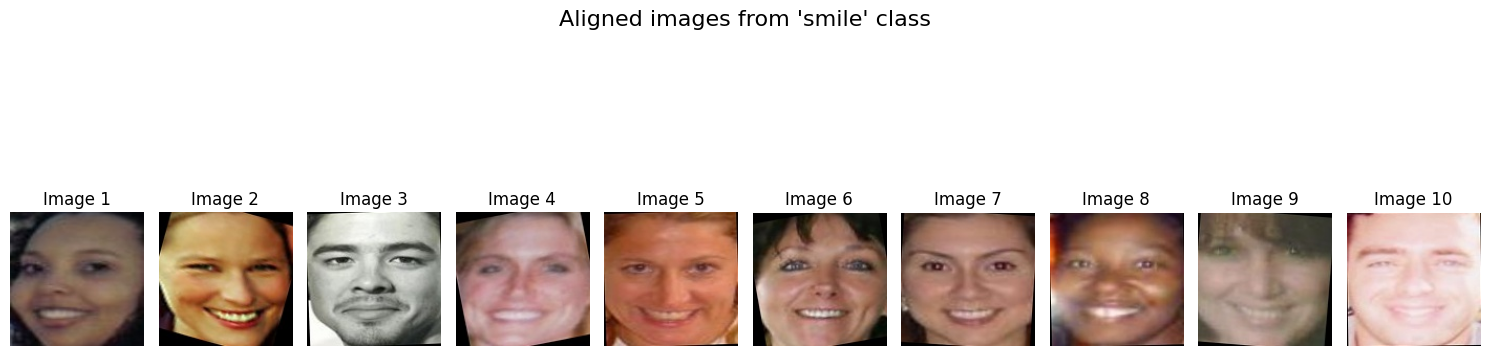

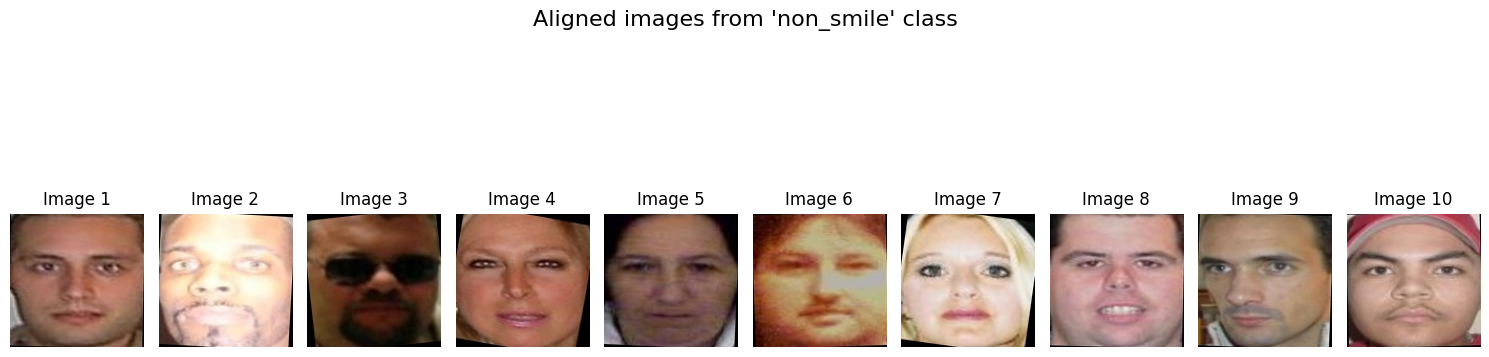

In [7]:
import os
import cv2
import matplotlib.pyplot as plt

# Path to the aligned dataset
classes = ['smile', 'non_smile']

# Number of images to display
num_images = 10  # You can change this to display more or fewer images

# Display images from each class
for class_name in classes:
    class_path = os.path.join(output_aligned_path, class_name)
    image_files = os.listdir(class_path)[:num_images]  # Get the first `num_images` images

    # Plot the images
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Aligned images from '{class_name}' class", fontsize=16)

    for i, image_name in enumerate(image_files):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not read image {image_path}. Skipping.")
            continue


        # Convert BGR to RGB for correct color display
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image in a subplot
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.title(f"Image {i + 1}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [8]:
"""
download the .hdf5 file of the pretrained model

"""
import locale
def set_utf8_locale():
    # Try setting the locale to en_US.UTF-8.
    try:
        locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
        return True
    except locale.Error:
        # If en_US.UTF-8 is not available, try other UTF-8 locales.
        for loc in ['en_US.utf8', 'C.UTF-8']:
            try:
                locale.setlocale(locale.LC_ALL, loc)
                return True
            except locale.Error:
                pass
        return False  # Return False if no suitable locale was found.

if set_utf8_locale():
    print("Locale set to UTF-8 successfully.")
else:
    print("Warning: Could not set locale to UTF-8. Some functionality may be affected.")

import os
# Set locale to UTF-8 using environment variables
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'

# Download the HDF5 file using the os module
os.system('wget -O file.hdf5 https://github.com/meng1994412/Smile_Detection/raw/master/output/lenet.hdf5')

Locale set to UTF-8 successfully.


0

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models


# Load the model from the .hdf5 file
model = tf.keras.models.load_model('file.hdf5')

# Print the model summary to understand its architecture
model.summary()

for layer in model.layers:
    layer.trainable = True

x = model.layers[-2].output
x = layers.Dense(32, activation='relu', name='custom_dense1')(x)
x = layers.Dropout(0.5, name='custom_drop1')(x)
x = layers.Dense(32, activation='relu', name='custom_dense2')(x)
x = layers.Dense(16, activation='relu', name='custom_dense3')(x)
x = layers.Dropout(0.5, name='custom_drop2')(x)
x = layers.Dense(16, activation='relu', name='custom_dense4')(x)
x = layers.Dense(4, activation='relu', name='custom_dense5')(x)
output = layers.Dense(1, activation='sigmoid', name='custom_dense6')(x)

model = models.Model(inputs=model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 20)        520       
                                                                 
 activation_1 (Activation)   (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 20)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_2 (Activation)   (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 50)          0         
 g2D)                                                 

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = output_aligned_path

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest'
)

# Create data loaders
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=25,
    class_mode='binary',
    color_mode='grayscale',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=25,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation'
)

batch = next(train_generator)
print("Input data shape:", batch[0].shape)
print("Label shape:", batch[1].shape)

for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}")

Found 3152 images belonging to 2 classes.
Found 787 images belonging to 2 classes.
Input data shape: (25, 28, 28, 1)
Label shape: (25,)
Layer 0: conv2d_1_input
Layer 1: conv2d_1
Layer 2: activation_1
Layer 3: max_pooling2d_1
Layer 4: conv2d_2
Layer 5: activation_2
Layer 6: max_pooling2d_2
Layer 7: flatten_1
Layer 8: dense_1
Layer 9: activation_3
Layer 10: dense_2
Layer 11: custom_dense1
Layer 12: custom_drop1
Layer 13: custom_dense2
Layer 14: custom_dense3
Layer 15: custom_drop2
Layer 16: custom_dense4
Layer 17: custom_dense5
Layer 18: custom_dense6


In [14]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf

for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name} - Input shape: {layer.input_shape}, Output shape: {layer.output_shape}")

#for checking the val_loss
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0)

history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    #batch_size=128,
    epochs=25,
    #verbose=1,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[early_stopping])

Layer 0: conv2d_1_input - Input shape: [(None, 28, 28, 1)], Output shape: [(None, 28, 28, 1)]
Layer 1: conv2d_1 - Input shape: (None, 28, 28, 1), Output shape: (None, 28, 28, 20)
Layer 2: activation_1 - Input shape: (None, 28, 28, 20), Output shape: (None, 28, 28, 20)
Layer 3: max_pooling2d_1 - Input shape: (None, 28, 28, 20), Output shape: (None, 14, 14, 20)
Layer 4: conv2d_2 - Input shape: (None, 14, 14, 20), Output shape: (None, 14, 14, 50)
Layer 5: activation_2 - Input shape: (None, 14, 14, 50), Output shape: (None, 14, 14, 50)
Layer 6: max_pooling2d_2 - Input shape: (None, 14, 14, 50), Output shape: (None, 7, 7, 50)
Layer 7: flatten_1 - Input shape: (None, 7, 7, 50), Output shape: (None, 2450)
Layer 8: dense_1 - Input shape: (None, 2450), Output shape: (None, 500)
Layer 9: activation_3 - Input shape: (None, 500), Output shape: (None, 500)
Layer 10: dense_2 - Input shape: (None, 500), Output shape: (None, 2)
Layer 11: custom_dense1 - Input shape: (None, 2), Output shape: (None, 32)

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# Save the model
model.save('retrained_smile_nonsmile.h5')
print("Model saved as 'retrained_smile_nonsmile.h5'")

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy:.2%}')



Model saved as 'retrained_smile_nonsmile.h5'
32/32 [==============================] - 0s 13ms/step - loss: 0.2872 - accuracy: 0.8895
Validation Accuracy: 88.95%


In [20]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!cp retrained_smile_nonsmile.h5 /content/drive/MyDrive

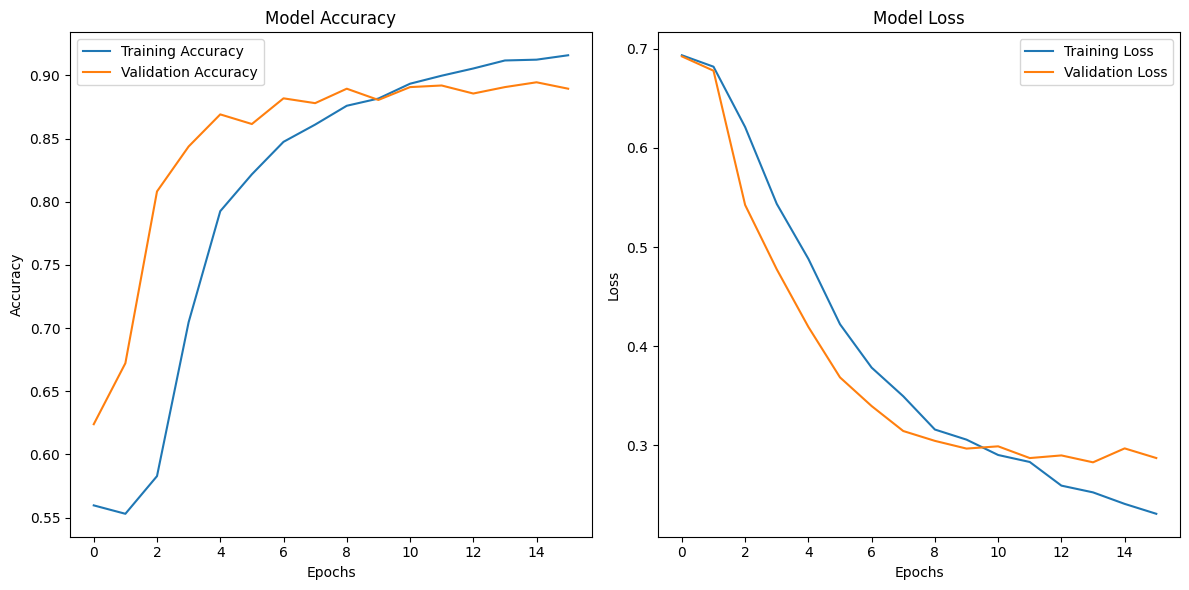

In [21]:
"""
plotting the metrics

"""
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


In [ ]:
"""
download the mp4 file for testing

"""
import locale
def set_utf8_locale():
    # Try setting the locale to en_US.UTF-8.
    try:
        locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
        return True
    except locale.Error:
        # If en_US.UTF-8 is not available, try other UTF-8 locales.
        for loc in ['en_US.utf8', 'C.UTF-8']:
            try:
                locale.setlocale(locale.LC_ALL, loc)
                return True
            except locale.Error:
                pass
        return False  # Return False if no suitable locale was found.

if set_utf8_locale():
    print("Locale set to UTF-8 successfully.")
else:
    print("Warning: Could not set locale to UTF-8. Some functionality may be affected.")

import os
# Set locale to UTF-8 using environment variables
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'

# Download the mp4 file using the os module
os.system('wget -O test.mp4 https://youtu.be/nA1dXR7im7o')

Locale set to UTF-8 successfully.


0

In [25]:
"""
test section, testing the model using a short video.

"""

import cv2
import numpy as np
from tensorflow.keras.models import load_model
from retinaface import RetinaFace

# Load the pre-trained model
model = load_model('retrained_smile_nonsmile.h5')

# Open the video file
video_path = '/content/People Smiling (No sound).mp4'
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Define the codec and create VideoWriter object
output_path = 'output_video_with_predictions.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Process the video frame by frame
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Exit loop when the video ends

    # Detect faces using RetinaFace
    detections = RetinaFace.detect_faces(frame)

    if isinstance(detections, dict):
        for key in detections:
            face_info = detections[key]
            facial_area = face_info['facial_area']
            x1, y1, x2, y2 = facial_area

            # Crop the detected face
            face_crop = frame[y1:y2, x1:x2]

            # Resize the cropped face to 128x128
            resized_face = cv2.resize(face_crop, (128, 128))
            resized_face = cv2.resize(face_crop, (28, 28))
            # Convert to grayscale
            gray_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2GRAY)

            # Normalize and reshape for the model
            normalized_face = gray_face / 255.0
            input_face = np.expand_dims(normalized_face, axis=(0, -1))  # Shape: (1, 28, 28, 1)

            # Predict using the model
            prediction = model.predict(input_face)
            label = 'Smile' if prediction[0] > 0.5 else 'No Smile'

            # Overlay the prediction text on the frame
            font = cv2.FONT_HERSHEY_SIMPLEX
            text_color = (0, 255, 0) if label == 'Smile' else (0, 0, 255)  # Green for smile, red for no smile
            cv2.putText(frame, f'Prediction: {label}', (x1, y1 - 10), font, 1, text_color, 2, cv2.LINE_AA)

            cv2.rectangle(frame, (x1, y1), (x2, y2), text_color, 2)

    # Write the frame to the output video
    out.write(frame)

    # Print progress
    frame_count += 1
    print(f'Processing frame {frame_count}/{total_frames}', end='\r')

cap.release()
out.release()
cv2.destroyAllWindows()

print("\nVideo processing complete. Output saved to:", output_path)


import locale
locale.getpreferredencoding = lambda: "UTF-8"

!cp output_video_with_predictions.avi /content/drive/MyDrive

1/1 [==============================] - 0s 28ms/step
Processing frame 480/3874
Video processing complete. Output saved to: output_video_with_predictions.avi
